### Introduction

In this kernel we're going to to predict machine breakdown based on its indicators. There are more than 50 of them and all of which are unnamed. Therefore, we also need to understand how much we can reduce the number of available dimensions to simplify calculations.

Thus we have two questions on the way:
1. Which model do we need to accurately predict machine breakdown?
2. What is the intrinsic dimension of the data provided?

Because of the provided marked data and output as classes, we have a classification problem. 
Thus we're going to use some of the most popular classfiying models:
* Logistic Regression
* Decision Tree
* Random Forest Classifier
* k-Nearest Neighbors 
* Support Vector Machines


For the second question we're going to use the principal component analysis to reveal how many dimensions contribute to the output the most. Thus let us open the veil and figure out which indicators help us predict the future of the machine.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, cross_val_score

import statsmodels.discrete.discrete_model as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

import time

### Looking at the data

In [2]:
X = pd.read_csv('./data/xtrain.csv')

In [3]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
0,-42.822536,NaN,12.0,NaN,1.0,2.0,24.0,-45.025510,NaN,1.0,...,17.871210,4.0,15.0,21.863365,-13.349394,-2.215086,-5.137377,20.904186,53.939262,-17.328346
1,-13.478816,13.0,12.0,75.132502,0.0,2.0,24.0,-49.213545,7.0,0.0,...,21.511019,2.0,13.0,-2.880103,21.739125,5.464161,-30.347612,23.304507,47.746225,-47.305489
2,51.702721,13.0,12.0,63.459270,0.0,3.0,24.0,-58.777043,8.0,0.0,...,NaN,3.0,16.0,21.851623,NaN,7.471764,-12.348314,34.406243,34.479515,-33.326172
3,NaN,12.0,13.0,-15.492561,1.0,1.0,23.0,0.624258,9.0,0.0,...,16.964848,2.0,15.0,-25.128119,-26.858262,54.203501,10.341217,29.080753,40.235855,-35.835956
4,7.633273,NaN,13.0,59.862681,0.0,3.0,NaN,-61.395319,NaN,0.0,...,8.467076,4.0,14.0,30.610006,-15.663721,38.323843,-65.561821,33.965883,50.245794,-44.018245


It is already easy to see a bunch of NaN values. And these have to be filled in because simply omitting NaNs dramatically reduces the size of our data. Just look:

In [4]:
print('Initial size: {}'.format(X.shape))
print('After NaN omit size: {}'.format(X.dropna().shape))

Initial size: (5000, 58)
After NaN omit size: (15, 58)


We may try to fill missing data, although we risk creating skewness.

In [5]:
X = X.fillna(method='bfill').fillna(method='ffill')
X.head()

,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
0,-42.822536,13.0,12.0,75.132502,1.0,2.0,24.0,-45.025510,7.0,1.0,...,17.871210,4.0,15.0,21.863365,-13.349394,-2.215086,-5.137377,20.904186,53.939262,-17.328346
1,-13.478816,13.0,12.0,75.132502,0.0,2.0,24.0,-49.213545,7.0,0.0,...,21.511019,2.0,13.0,-2.880103,21.739125,5.464161,-30.347612,23.304507,47.746225,-47.305489
2,51.702721,13.0,12.0,63.459270,0.0,3.0,24.0,-58.777043,8.0,0.0,...,16.964848,3.0,16.0,21.851623,-26.858262,7.471764,-12.348314,34.406243,34.479515,-33.326172
3,7.633273,12.0,13.0,-15.492561,1.0,1.0,23.0,0.624258,9.0,0.0,...,16.964848,2.0,15.0,-25.128119,-26.858262,54.203501,10.341217,29.080753,40.235855,-35.835956
4,7.633273,13.0,13.0,59.862681,0.0,3.0,23.0,-61.395319,7.0,0.0,...,8.467076,4.0,14.0,30.610006,-15.663721,38.323843,-65.561821,33.965883,50.245794,-44.018245


Next we import our desired labels, our classes which we will predict later.

In [6]:
y = pd.read_csv('./data/ytrain.csv')

In [7]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       5000 non-null   int64
dtypes: int64(1)
memory usage: 39.2 KB


And convert loaded y into array to work with **train_test_split** function.

In [8]:
y = np.array(y).ravel()

### Defining the models to use

As it was mentioned before - we're soling a classification problem. Fortunately, there are a lot of powerful classifiers. However we're going to use only fraction of them:
* Logistic Regression
* Decision Tree
* Random Forest Classifier
* k-Nearest Neighbors 
* Support Vector Machines


#### Train and test dataset splitting

For models tests we have to split training data into train and test parts.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#### Logistic Regression Test Statistics

Before the actual modelling and prediction let us see the impact of the variables (features) and their significance. For that we're going to use model estimation statistics.

There will be a lot of indicators, but basically we are interested in:
* Pseudo R squared as one of the important indicators of model quality
* P-value of each variable as the indicator of variable significance

In [10]:
model = sm.Logit(y_train, X_train)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.605355
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2942
Method:                           MLE   Df Model:                           57
Date:                Tue, 27 Dec 2022   Pseudo R-squ.:                 0.01531
Time:                        17:07:32   Log-Likelihood:                -1816.1
converged:                       True   LL-Null:                       -1844.3
Covariance Type:            nonrobust   LLR p-value:                    0.4949
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1              0.0003      0.000      0.806      0.420      -0.000       0.001
2              0.0334      0.

The pseudo R squared is super low. That means our model is not much better than predicting average value. Let's take a look if there will be an improvement if we choose variables with p-value equal or lower 10%. 

In [11]:
sig_columns = [i for i,x in enumerate(result.pvalues.ravel()) if x<=0.1]

X_train.iloc[:,sig_columns].head()

,3,29,35,42,45
4576,14.0,2.0,-23.734065,-2.137954,10.0
1088,12.0,1.0,-47.587401,-0.346686,10.0
479,11.0,3.0,-56.009386,3.095804,11.0
727,14.0,3.0,-45.692497,0.031271,11.0
3783,10.0,2.0,-69.954678,7.427580,9.0


In [12]:
model = sm.Logit(y_train, X_train.iloc[:,sig_columns])
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.611043
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2995
Method:                           MLE   Df Model:                            4
Date:                Tue, 27 Dec 2022   Pseudo R-squ.:                0.006057
Time:                        17:07:33   Log-Likelihood:                -1833.1
converged:                       True   LL-Null:                       -1844.3
Covariance Type:            nonrobust   LLR p-value:                 0.0001714
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
3             -0.0341      0.021     -1.645      0.100      -0.075       0.007
29             0.0514      0.

Well. Now we have that our reduction from 58 features to 11 led us to even lower R squared.

#### The PCA

Principal Component Analysis.

With this analysis we may understand how much we can reduce the number of our dimensions to exclude the noise in the data. And we may also transorm the data in a way to get components which determine the highest variance of the data and thus the greatest impact.

But before we start transform our data, we need to determine the number of components we want to use. For this we're going to use histogram of explained variances by the number of PCA features. 

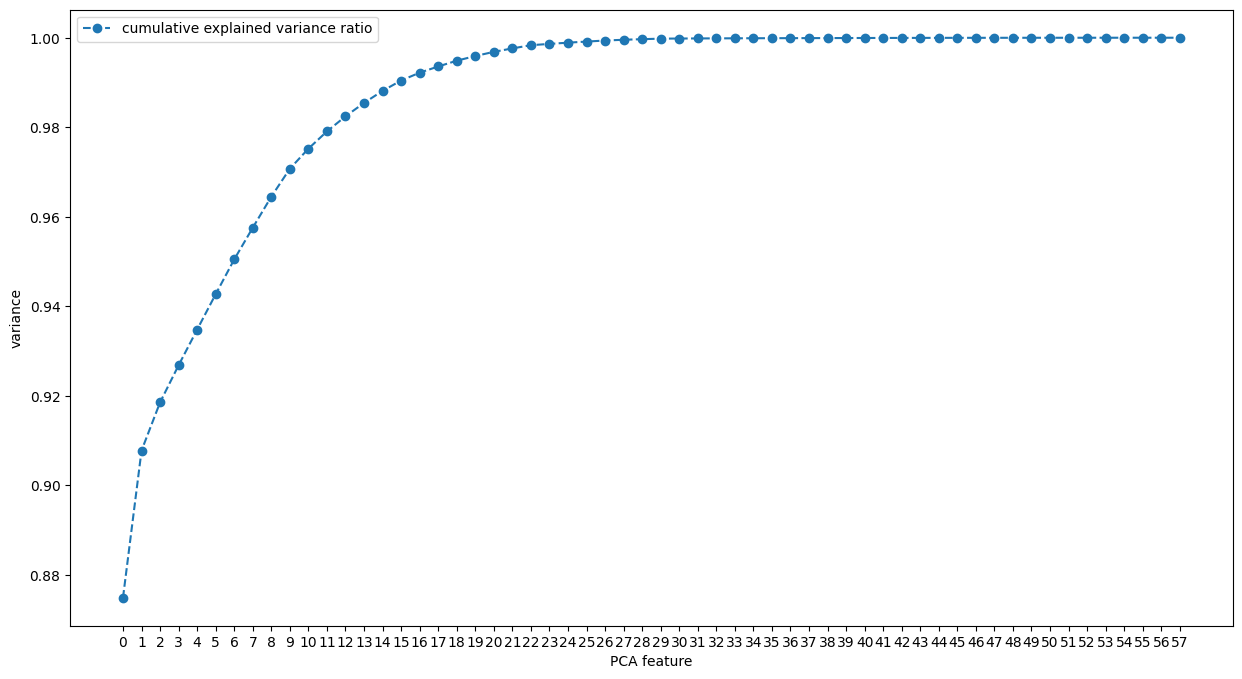

In [13]:
pca = PCA()

pca.fit(X_train)
plt.figure(figsize=(15, 8))
features = range(pca.n_components_)
plt.plot(features, pca.explained_variance_ratio_.cumsum(),'--o', label='cumulative explained variance ratio')
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.legend()
plt.show()

As can be clearly seen from the chart with a single component we can explain **~88%** of the variance!

If we want to be closer to a normal distribution or there are problems with feature scales, we may normalize our data. With normalization we might see the contribution of other components as well.

Therefore, let us look at the original features' variance:

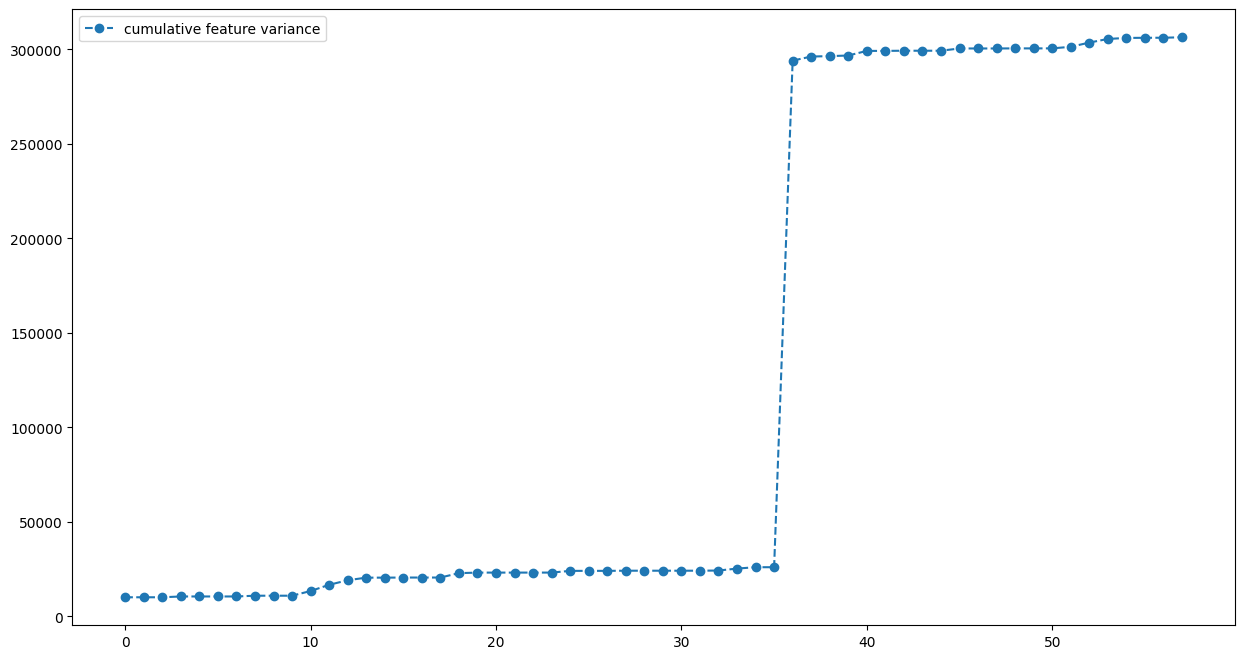

In [14]:
plt.figure(figsize=(15,8))
plt.plot(range(0,58),X_train.var().cumsum(),'--o', label="cumulative feature variance")
plt.legend()
plt.show()

It looks like the 36th variable has outstanding variance. Thus rescaling is needed.

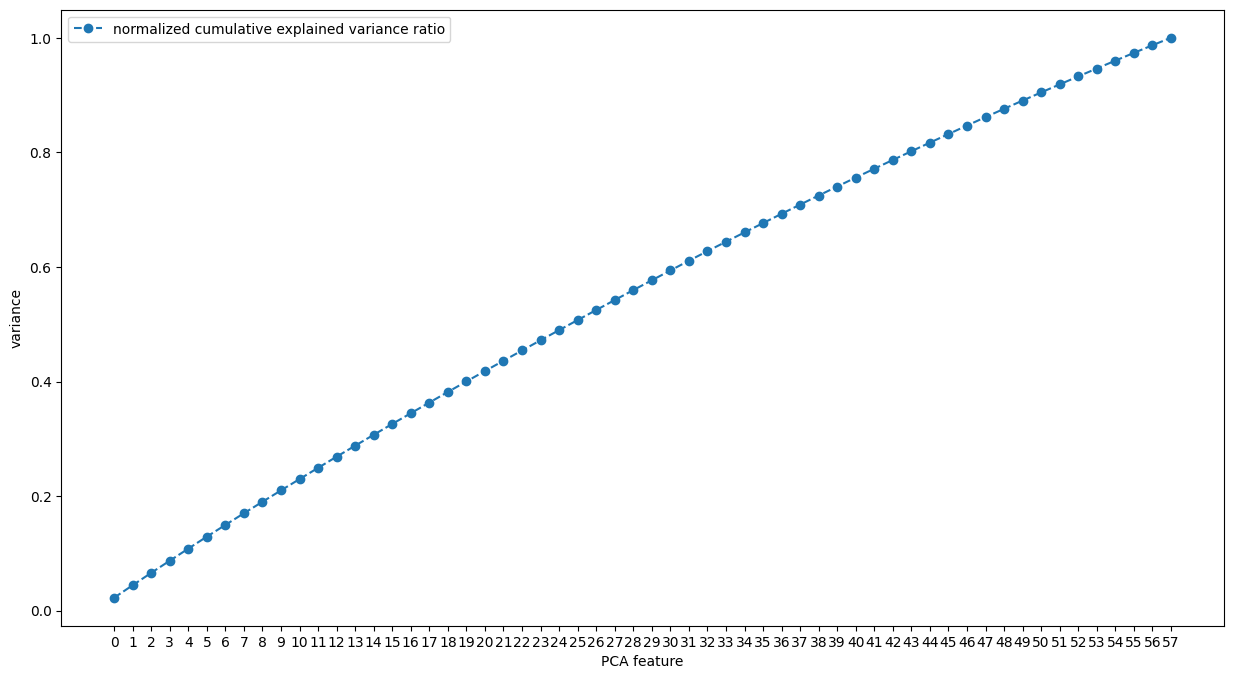

In [15]:
scaler = StandardScaler()

pca = PCA()

pipeline = make_pipeline(scaler, pca)

pipeline.fit(X_train)

plt.figure(figsize=(15, 8))
features = range(pca.n_components_)
plt.plot(features, pca.explained_variance_ratio_.cumsum(),'--o', label='normalized cumulative explained variance ratio')
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.legend()
plt.show()

Well, now we have that all our components have equal contribution. That is strange. However, let's give it a chance.

In [16]:
pca_X_train = pipeline.transform(X_train)
pca_X_test = pipeline.transform(X_test)

print('pca_X_train shape: {}'.format(pca_X_train.shape))
print('pca_X_test shape: {}'.format(pca_X_test.shape))

pca_X_train shape: (3000, 58)
pca_X_test shape: (2000, 58)


#### Modelling without PCA features

From now we are going to implement imported models to see the difference in accuracy, log loss and time usage. And no PCA will be applied.

With such decision we get the opportunity to compare the performance not only between models but also between used features.

In [17]:
def compute_models(X_train, y_train, X_test, y_test):
    results={}
    def test_model(model):
        start_time = time.time()
        
        model.fit(X_train, y_train)
        test_accuracy = model.score(X_test, y_test)
        model_probs = model.predict_proba(X_test)
        test_log_loss = log_loss(y_test, model_probs)
        cv_acc = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5)
        
        scores= [cv_acc.mean(), test_accuracy, test_log_loss, (time.time() - start_time)]
        return scores
    m = LogisticRegression()
    results['Logistic Regression'] = test_model(m)
    
    for i in range(6, 15, 4):
        m = DecisionTreeClassifier(max_depth=3, min_samples_leaf=i)
        results['Decision tree {}'.format(i)] = test_model(m)
    
    for i in range(60,150,40):
        m = RandomForestClassifier(n_estimators=i)
        results['Random forest {}'.format(i)] = test_model(m)
    
    for i in range(6,15,4):
        m = KNeighborsClassifier(n_neighbors = i)
        results['KNN {}'.format(i)] = test_model(m)
        
    m = SVC(probability=True)
    results['SVM'] = test_model(m)
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["Train mean accuracy", "Test accuracy", "Test log loss", "Time duration (sec)"] 
    results=results.sort_values(by=["Test accuracy","Test log loss"],ascending=[False,True])

    return results

In [18]:
no_pca_results = compute_models(X_train, y_train, X_test, y_test)
no_pca_results

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

,Train mean accuracy,Test accuracy,Test log loss,Time duration (sec)
Random forest 100,0.694333,0.6985,0.623871,10.969591
Random forest 140,0.695000,0.6980,0.619746,12.111124
SVM,0.695333,0.6975,0.612710,31.886543
Decision tree 6,0.686000,0.6975,0.624203,0.233759
Decision tree 10,0.687333,0.6975,0.624203,0.227315
Decision tree 14,0.686667,0.6975,0.624203,0.224374
Logistic Regression,0.692667,0.6970,0.618028,0.356637
Random forest 60,0.692000,0.6910,0.629158,7.971828
KNN 14,0.685000,0.6765,0.704889,0.413642
KNN 10,0.679333,0.6760,0.803104,0.384195


#### Modelling with PCA

Alright, we have got that our Logistic Regression does not converge, which means we cannot even reach local optima. Thus, chances are that the data needs to be normalized.

Running models with every PCA feature:

In [19]:
pca_results = compute_models(pca_X_train, y_train, pca_X_test, y_test)
pca_results

,Train mean accuracy,Test accuracy,Test log loss,Time duration (sec)
Random forest 140,0.693667,0.6980,0.617620,18.177571
SVM,0.695333,0.6975,0.612495,30.344231
Decision tree 14,0.691000,0.6965,0.621001,0.331531
Logistic Regression,0.691000,0.6960,0.620520,0.084482
Decision tree 6,0.694000,0.6950,0.620449,0.364224
Decision tree 10,0.694000,0.6950,0.620449,0.333226
Random forest 100,0.695000,0.6940,0.625869,13.440646
Random forest 60,0.691333,0.6935,0.624030,8.063307
KNN 10,0.676000,0.6875,0.994688,0.353685
KNN 14,0.685667,0.6870,0.763145,0.358193


Great! We resolved the issue with convergence.

Computing the PCA without rescaling data and with only one component.

In [20]:
pca = PCA(n_components=1)

pca.fit(X_train)

pca1_X_train = pca.transform(X_train)
pca1_X_test = pca.transform(X_test)

print('pca_X_train shape: {}'.format(pca1_X_train.shape))
print('pca_X_test shape: {}'.format(pca1_X_test.shape))

pca_X_train shape: (3000, 1)
pca_X_test shape: (2000, 1)


After calculation let us see the difference in results with only one, not normalized PCA component:

In [21]:
pca_results = compute_models(pca1_X_train, y_train, pca1_X_test, y_test)
pca_results

,Train mean accuracy,Test accuracy,Test log loss,Time duration (sec)
Logistic Regression,0.695333,0.6975,0.612973,0.153043
SVM,0.695333,0.6975,0.613511,7.896293
Decision tree 10,0.692667,0.6970,0.611704,0.018320
Decision tree 14,0.691333,0.6970,0.620553,0.018187
Decision tree 6,0.695000,0.6965,0.684770,0.019183
KNN 14,0.681333,0.6800,0.672109,0.159124
KNN 10,0.684000,0.6670,0.989122,0.162811
KNN 6,0.676000,0.6630,1.732836,0.157490
Random forest 140,0.577333,0.5845,2.165660,5.093481
Random forest 100,0.578333,0.5845,2.278976,3.622857


Wait what. We have got almost the same results using only one PCA feature? And look how we improved the calculation time!

### The fastest models

By now we have observed, there is no big difference in test accuracy between models and feature selection.

There are models which have almost the same accuracy and log loss, although they are significantly faster than the fastest one:
* Decision Tree
* KNN


In [22]:
def draw_models(model_str,X_train, y_train, X_test, y_test, range_):
    test_accuracy = [0]*len(range_)
    test_log_loss = [0]*len(range_)
    def test_model(model):
        model.fit(X_train, y_train)
        test_accuracy = model.score(X_test, y_test)
        model_probs = model.predict_proba(X_test)
        test_log_loss = log_loss(y_test, model_probs)
        return test_accuracy, test_log_loss
    if (model_str=='DT'):
        for i,x in enumerate(range_):
            m = DecisionTreeClassifier(max_depth=3, min_samples_leaf=x)
            test_accuracy[i], test_log_loss[i] = test_model(m)
    else:
        for i,x in enumerate(range_):
            m = KNeighborsClassifier(n_neighbors = x)
            test_accuracy[i], test_log_loss[i] = test_model(m)
    
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(range_, test_accuracy,'--o', label='Test accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(range_, test_log_loss,'--o', label='Test log loss')
    plt.legend()
    plt.show()

#### Decision Tree

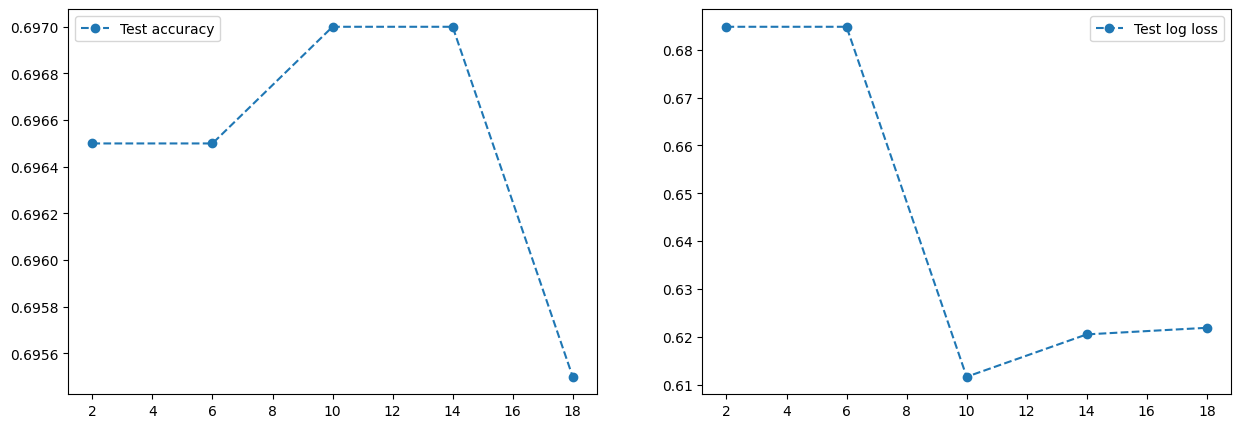

In [23]:
draw_models('DT',pca1_X_train, y_train, pca1_X_test, y_test,range(2,20,4))

Interesting that with 10 as the minimum number of samples at a leaf node we get a compromise between test accuracy and log loss.

#### KNN

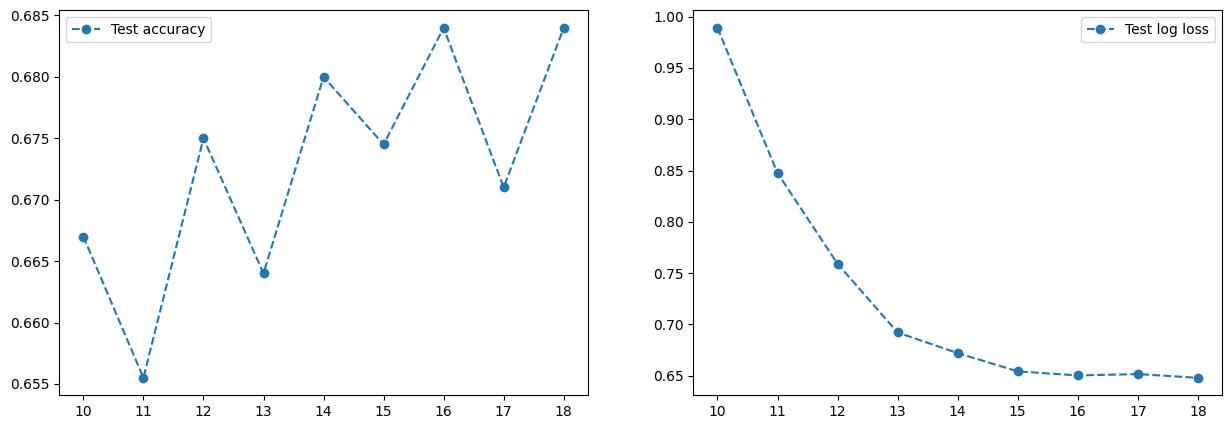

In [24]:
draw_models('KNN',pca1_X_train, y_train, pca1_X_test, y_test,range(10,19))

Thus the KNN gives us 16 as the comromise point.

### Temporary Conclusion

We have observed that Logistic Regression, Decision Tree and KNN algorithms lead in the group of classifiers given their results and speed.

The second interesting thing is that we got the same models performance with only one PCA component applied. Which means we greatly reduced the computational time and kept the results as well.

On the other hand, we have got only ~70% test accuracy and ~0.61 log loss. Therefore, there is still a need to find better approach than what was used above.